In [5]:
import os
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pandas as pd
import cv2

In [6]:
def measurement(outputs, labels, smooth=1e-10):
    tp, tn, fp, fn = smooth, smooth, smooth, smooth
    labels = labels.cpu().numpy()
    outputs = outputs.detach().cpu().clone().numpy()
    for j in range(labels.shape[0]):
        if (int(outputs[j]) == 1 and int(labels[j]) == 1):
            tp += 1
        if (int(outputs[j]) == 0 and int(labels[j]) == 0):
            tn += 1
        if (int(outputs[j]) == 1 and int(labels[j]) == 0):
            fp += 1
        if (int(outputs[j]) == 0 and int(labels[j]) == 1):
            fn += 1
    return tp, tn, fp, fn

def plot_accuracy(train_acc_list, val_acc_list):
    plt.plot(train_acc_list)
    plt.ylabel('Train Accuracy')
    plt.savefig('Train_Accuracy.png')
    plt.show()
    plt.plot(val_acc_list)
    plt.ylabel('Test Accuracy')
    plt.savefig('Test_Accuracy.png')
    plt.show()

def plot_f1_score(f1_score_list):
    plt.plot(f1_score_list)
    plt.ylabel('Test F1 Score')
    plt.savefig('Test_F1_Score.png')
    plt.show()

def plot_confusion_matrix(confusion_matrix):
    csum = confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1]
    confusion_matrix[0][0] = confusion_matrix[0][0] / csum
    confusion_matrix[0][1] = confusion_matrix[0][1] / csum
    confusion_matrix[1][0] = confusion_matrix[1][0] / csum
    confusion_matrix[1][1] = confusion_matrix[1][1] / csum
    df_cm = pd.DataFrame(confusion_matrix, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
    sns.heatmap(df_cm, annot=True)
    plt.savefig('Confusion_Matrix.png')

def train(device, train_loader, model, criterion, optimizer):
    best_acc = 0.0
    best_model_wts = None
    train_acc_list = []
    val_acc_list = []
    f1_score_list = []
    best_c_matrix = []

    for epoch in range(1, args.num_epochs+1):

        with torch.set_grad_enabled(True):
            avg_loss = 0.0
            train_acc = 0.0
            tp, tn, fp, fn = 0, 0, 0, 0 
            if epoch < 6:
                print('stage 1')
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.fc.parameters():
                    param.requires_grad = True
            else:
                print('stage 2')
                for param in model.parameters():
                    param.requires_grad = True
            for _, data in enumerate(tqdm(train_loader)):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                avg_loss += loss.item()
                outputs = torch.max(outputs, 1).indices
                sub_tp, sub_tn, sub_fp, sub_fn = measurement(outputs, labels)
                tp += sub_tp
                tn += sub_tn
                fp += sub_fp
                fn += sub_fn          

            avg_loss /= len(train_loader.dataset)
            train_acc = (tp+tn) / (tp+tn+fp+fn) * 100
            print(f'Epoch: {epoch}')
            print(f'↳ Loss: {avg_loss}')
            print(f'↳ Training Acc.(%): {train_acc:.2f}%')

        val_acc, f1_score, c_matrix = test(test_loader, model)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        f1_score_list.append(f1_score)

        if val_acc > best_acc:
            best_acc = val_acc
            best_c_matrix = c_matrix
            torch.save(model.state_dict(), 'best_model_weights.pt')
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvment {patience} consecutive epochs, early stopping")
                break

    return train_acc_list, val_acc_list, f1_score_list, best_c_matrix

def test(test_loader, model):
    val_acc = 0.0
    tp, tn, fp, fn = 0, 0, 0, 0
    with torch.set_grad_enabled(False):
        model.eval()
        for images, labels in test_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = torch.max(outputs, 1).indices

            sub_tp, sub_tn, sub_fp, sub_fn = measurement(outputs, labels)
            tp += sub_tp
            tn += sub_tn
            fp += sub_fp
            fn += sub_fn

        c_matrix = [[int(tp), int(fn)],
                    [int(fp), int(tn)]]
        
        val_acc = (tp+tn) / (tp+tn+fp+fn) * 100
        recall = tp / (tp+fn)
        precision = tp / (tp+fp)
        f1_score = (2*tp) / (2*tp+fp+fn)
        print (f'↳ Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1_score:.4f}')
        print (f'↳ Test Acc.(%): {val_acc:.2f}%')

    return val_acc, f1_score, c_matrix

In [7]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=UserWarning)

    parser = ArgumentParser()

    # for model
    parser.add_argument('--num_classes', type=int, required=False, default=2)

    # for training
    parser.add_argument('--num_epochs', type=int, required=False, default=60)
    parser.add_argument('--batch_size', type=int, required=False, default=128)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--wd', type=float, default=0.01)

    # for dataloader
    parser.add_argument('--dataset', type=str, required=False, default='chest_xray')

    # for data augmentation
    parser.add_argument('--degree', type=int, default=90)
    parser.add_argument('--resize', type=int, default=224)

    args, unknown = parser.parse_known_args()

    # set gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'## Now using {device} as calculating device ##')

    # set dataloader
    train_dataset = ImageFolder(root=os.path.join(args.dataset, 'train'),
                                transform = transforms.Compose([transforms.Resize((args.resize, args.resize)),
                                                                transforms.ColorJitter(brightness=(0.7, 1.3), contrast=(0.7,1.3)),
                                                                transforms.RandomRotation(args.degree),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                                                ]))
    test_dataset = ImageFolder(root=os.path.join(args.dataset, 'test'),
                               transform = transforms.Compose([transforms.Resize((args.resize, args.resize)),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                                               ]))

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # define model
    model = models.resnet50(pretrained=True)
    num_neurons = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_neurons, 64), nn.Linear(64, args.num_classes), nn.Sigmoid())
    model = model.to(device)

    # define loss function, optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([3.8896346, 1.346]))
    criterion = criterion.to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
    
    #early stopping
    stale = 0
    patience = 20

## Now using cuda as calculating device ##


In [8]:
# training
train_acc_list, val_acc_list, f1_score_list, best_c_matrix = train(device, train_loader, model, criterion, optimizer)

100%|██████████| 41/41 [01:49<00:00,  2.67s/it]


Epoch: 1
↳ Loss: 0.0054485068250836035
↳ Training Acc.(%): 49.10%
↳ Recall: 0.0692, Precision: 0.6279, F1-score: 0.1247
↳ Test Acc.(%): 39.26%


100%|██████████| 41/41 [01:48<00:00,  2.65s/it]


Epoch: 2
↳ Loss: 0.005429660947136352
↳ Training Acc.(%): 38.88%
↳ Recall: 0.2974, Precision: 0.9915, F1-score: 0.4576
↳ Test Acc.(%): 55.93%


100%|██████████| 41/41 [01:55<00:00,  2.81s/it]


Epoch: 3
↳ Loss: 0.0053106458640537375
↳ Training Acc.(%): 89.53%
↳ Recall: 0.8487, Precision: 0.9246, F1-score: 0.8850
↳ Test Acc.(%): 86.22%


100%|██████████| 41/41 [02:14<00:00,  3.28s/it]


Epoch: 4
↳ Loss: 0.00527425506866417
↳ Training Acc.(%): 93.25%
↳ Recall: 0.8692, Precision: 0.9237, F1-score: 0.8956
↳ Test Acc.(%): 87.34%


100%|██████████| 41/41 [02:19<00:00,  3.41s/it]


Epoch: 5
↳ Loss: 0.005266024691104158
↳ Training Acc.(%): 95.59%
↳ Recall: 0.8974, Precision: 0.9211, F1-score: 0.9091
↳ Test Acc.(%): 88.78%


100%|██████████| 41/41 [02:16<00:00,  3.34s/it]


Epoch: 6
↳ Loss: 0.0052654541046158665
↳ Training Acc.(%): 95.32%
↳ Recall: 0.9718, Precision: 0.8814, F1-score: 0.9244
↳ Test Acc.(%): 90.06%


100%|██████████| 41/41 [02:10<00:00,  3.18s/it]


Epoch: 7
↳ Loss: 0.0052652239022445094
↳ Training Acc.(%): 95.61%
↳ Recall: 0.9436, Precision: 0.9109, F1-score: 0.9270
↳ Test Acc.(%): 90.71%


100%|██████████| 41/41 [02:12<00:00,  3.24s/it]


Epoch: 8
↳ Loss: 0.00526308435146794
↳ Training Acc.(%): 95.59%
↳ Recall: 0.9385, Precision: 0.9127, F1-score: 0.9254
↳ Test Acc.(%): 90.54%


100%|██████████| 41/41 [02:06<00:00,  3.08s/it]


Epoch: 9
↳ Loss: 0.005261205571012263
↳ Training Acc.(%): 96.17%
↳ Recall: 0.9744, Precision: 0.9069, F1-score: 0.9394
↳ Test Acc.(%): 92.15%


100%|██████████| 41/41 [01:51<00:00,  2.72s/it]


Epoch: 10
↳ Loss: 0.005262598361065783
↳ Training Acc.(%): 95.90%
↳ Recall: 0.9974, Precision: 0.7780, F1-score: 0.8742
↳ Test Acc.(%): 82.05%


100%|██████████| 41/41 [01:49<00:00,  2.68s/it]


Epoch: 11
↳ Loss: 0.005265295265550994
↳ Training Acc.(%): 95.36%
↳ Recall: 0.9949, Precision: 0.8134, F1-score: 0.8950
↳ Test Acc.(%): 85.42%


100%|██████████| 41/41 [01:46<00:00,  2.60s/it]


Epoch: 12
↳ Loss: 0.005260804336678031
↳ Training Acc.(%): 96.68%
↳ Recall: 0.9795, Precision: 0.8863, F1-score: 0.9306
↳ Test Acc.(%): 90.87%


100%|██████████| 41/41 [01:49<00:00,  2.67s/it]


Epoch: 13
↳ Loss: 0.005264881849746031
↳ Training Acc.(%): 95.48%
↳ Recall: 0.9564, Precision: 0.9120, F1-score: 0.9337
↳ Test Acc.(%): 91.51%


100%|██████████| 41/41 [01:54<00:00,  2.80s/it]


Epoch: 14
↳ Loss: 0.00526532238246473
↳ Training Acc.(%): 95.07%
↳ Recall: 0.9974, Precision: 0.8259, F1-score: 0.9036
↳ Test Acc.(%): 86.70%


100%|██████████| 41/41 [01:52<00:00,  2.75s/it]


Epoch: 15
↳ Loss: 0.0052619684099054044
↳ Training Acc.(%): 96.40%
↳ Recall: 0.9897, Precision: 0.8694, F1-score: 0.9257
↳ Test Acc.(%): 90.06%


100%|██████████| 41/41 [01:56<00:00,  2.85s/it]


Epoch: 16
↳ Loss: 0.0052599225284680265
↳ Training Acc.(%): 96.63%
↳ Recall: 0.9769, Precision: 0.9093, F1-score: 0.9419
↳ Test Acc.(%): 92.47%


100%|██████████| 41/41 [02:07<00:00,  3.11s/it]


Epoch: 17
↳ Loss: 0.0052598556903608006
↳ Training Acc.(%): 96.49%
↳ Recall: 0.9949, Precision: 0.8033, F1-score: 0.8889
↳ Test Acc.(%): 84.46%


100%|██████████| 41/41 [02:09<00:00,  3.16s/it]


Epoch: 18
↳ Loss: 0.005262388396391108
↳ Training Acc.(%): 96.07%
↳ Recall: 0.9974, Precision: 0.8155, F1-score: 0.8973
↳ Test Acc.(%): 85.74%


100%|██████████| 41/41 [02:09<00:00,  3.15s/it]


Epoch: 19
↳ Loss: 0.005268639696339157
↳ Training Acc.(%): 94.38%
↳ Recall: 0.9949, Precision: 0.8203, F1-score: 0.8992
↳ Test Acc.(%): 86.06%


100%|██████████| 41/41 [01:58<00:00,  2.90s/it]


Epoch: 20
↳ Loss: 0.005263005114771837
↳ Training Acc.(%): 95.88%
↳ Recall: 0.9821, Precision: 0.8886, F1-score: 0.9330
↳ Test Acc.(%): 91.19%


100%|██████████| 41/41 [02:04<00:00,  3.05s/it]


Epoch: 21
↳ Loss: 0.005260561724290526
↳ Training Acc.(%): 96.26%
↳ Recall: 0.9872, Precision: 0.8710, F1-score: 0.9255
↳ Test Acc.(%): 90.06%


100%|██████████| 41/41 [02:12<00:00,  3.23s/it]


Epoch: 22
↳ Loss: 0.005260657233420325
↳ Training Acc.(%): 96.43%
↳ Recall: 0.9923, Precision: 0.8431, F1-score: 0.9117
↳ Test Acc.(%): 87.98%


100%|██████████| 41/41 [02:18<00:00,  3.37s/it]


Epoch: 23
↳ Loss: 0.005260507239063093
↳ Training Acc.(%): 96.64%
↳ Recall: 0.9821, Precision: 0.8744, F1-score: 0.9251
↳ Test Acc.(%): 90.06%


100%|██████████| 41/41 [02:06<00:00,  3.08s/it]


Epoch: 24
↳ Loss: 0.005264922439412106
↳ Training Acc.(%): 95.25%
↳ Recall: 0.9641, Precision: 0.9060, F1-score: 0.9342
↳ Test Acc.(%): 91.51%


100%|██████████| 41/41 [01:59<00:00,  2.91s/it]


Epoch: 25
↳ Loss: 0.005261250925850283
↳ Training Acc.(%): 96.34%
↳ Recall: 0.9974, Precision: 0.7138, F1-score: 0.8321
↳ Test Acc.(%): 74.84%


100%|██████████| 41/41 [01:18<00:00,  1.92s/it]


Epoch: 26
↳ Loss: 0.005271997782715991
↳ Training Acc.(%): 93.31%
↳ Recall: 0.9795, Precision: 0.8643, F1-score: 0.9183
↳ Test Acc.(%): 89.10%


100%|██████████| 41/41 [01:18<00:00,  1.90s/it]


Epoch: 27
↳ Loss: 0.005264222610490454
↳ Training Acc.(%): 95.49%
↳ Recall: 0.9744, Precision: 0.8941, F1-score: 0.9325
↳ Test Acc.(%): 91.19%


100%|██████████| 41/41 [01:17<00:00,  1.89s/it]


Epoch: 28
↳ Loss: 0.005267100271546036
↳ Training Acc.(%): 95.17%
↳ Recall: 0.9513, Precision: 0.9229, F1-score: 0.9369
↳ Test Acc.(%): 91.99%


100%|██████████| 41/41 [01:17<00:00,  1.89s/it]


Epoch: 29
↳ Loss: 0.00526892897770083
↳ Training Acc.(%): 94.10%
↳ Recall: 0.9641, Precision: 0.9082, F1-score: 0.9353
↳ Test Acc.(%): 91.67%


100%|██████████| 41/41 [01:24<00:00,  2.05s/it]


Epoch: 30
↳ Loss: 0.00526272929473523
↳ Training Acc.(%): 96.17%
↳ Recall: 0.9795, Precision: 0.8643, F1-score: 0.9183
↳ Test Acc.(%): 89.10%


100%|██████████| 41/41 [01:51<00:00,  2.72s/it]


Epoch: 31
↳ Loss: 0.005261573791960997
↳ Training Acc.(%): 96.30%
↳ Recall: 0.9897, Precision: 0.8319, F1-score: 0.9040
↳ Test Acc.(%): 86.86%


100%|██████████| 41/41 [01:45<00:00,  2.57s/it]


Epoch: 32
↳ Loss: 0.005266172262879968
↳ Training Acc.(%): 95.49%
↳ Recall: 0.9615, Precision: 0.9058, F1-score: 0.9328
↳ Test Acc.(%): 91.35%


100%|██████████| 41/41 [01:54<00:00,  2.80s/it]


Epoch: 33
↳ Loss: 0.005263029706258715
↳ Training Acc.(%): 96.07%
↳ Recall: 0.9769, Precision: 0.8523, F1-score: 0.9104
↳ Test Acc.(%): 87.98%


100%|██████████| 41/41 [01:56<00:00,  2.85s/it]


Epoch: 34
↳ Loss: 0.005264475610267165
↳ Training Acc.(%): 95.69%
↳ Recall: 0.9846, Precision: 0.8421, F1-score: 0.9078
↳ Test Acc.(%): 87.50%


100%|██████████| 41/41 [01:56<00:00,  2.83s/it]


Epoch: 35
↳ Loss: 0.005268347443887061
↳ Training Acc.(%): 94.84%
↳ Recall: 0.9769, Precision: 0.8600, F1-score: 0.9148
↳ Test Acc.(%): 88.62%


100%|██████████| 41/41 [02:00<00:00,  2.94s/it]


Epoch: 36
↳ Loss: 0.005267237775896224
↳ Training Acc.(%): 94.75%
↳ Recall: 0.9897, Precision: 0.8178, F1-score: 0.8956
↳ Test Acc.(%): 85.58%


100%|██████████| 41/41 [02:04<00:00,  3.03s/it]


Epoch: 37
↳ Loss: 0.005273898629231687
↳ Training Acc.(%): 93.52%
↳ Recall: 0.9615, Precision: 0.8824, F1-score: 0.9202
↳ Test Acc.(%): 89.58%
No improvment 20 consecutive epochs, early stopping


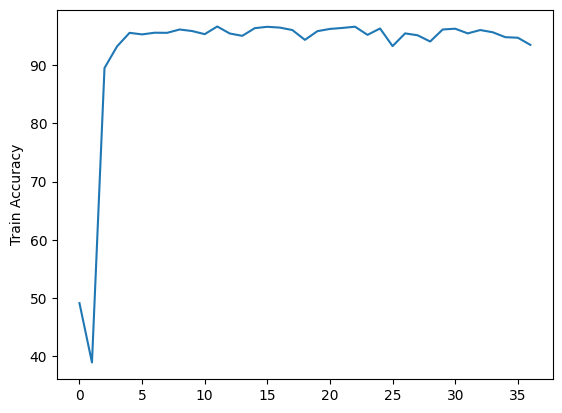

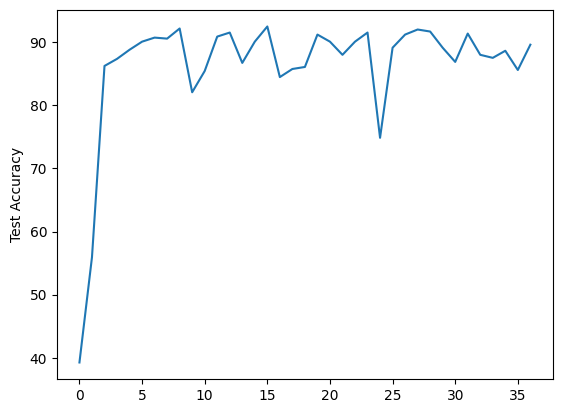

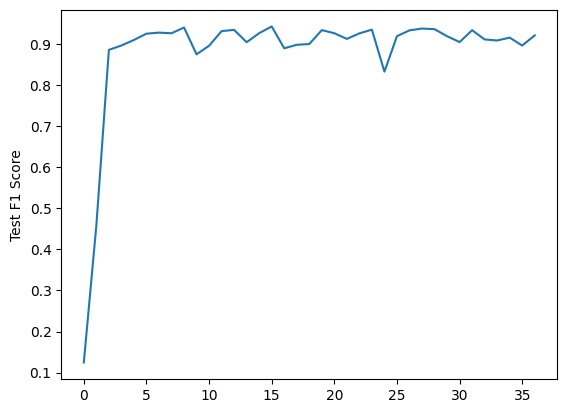

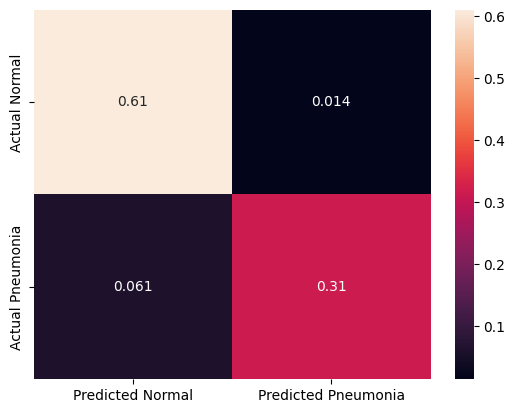

In [9]:
# plot
plot_accuracy(train_acc_list, val_acc_list)
plot_f1_score(f1_score_list)
plot_confusion_matrix(best_c_matrix)